# Video Transcription and Annotation

## Setup

In [3]:
import os
import glob
import pandas as pd
import numpy as np

#from moviepy.editor import *
#import moviepy.editor as mp
from moviepy.editor import VideoFileClip

import whisper

### Set Directories

In [4]:
proj_dir = '/Users/hpopal/Google Drive/My Drive/dscn_lab/projects/net/'
#proj_dir = '/Users/haroonpopal/hpopal@umd.edu - Google Drive/My Drive/dscn_lab/projects/net/'
data_dir = proj_dir+'derivatives/task-naturalistic/stimuli/'
outp_dir = proj_dir+'derivatives/reverse_correlation/'

audio_dir = proj_dir + 'derivatives/video_analysis/audio_files/subclips/'

os.chdir(proj_dir)

In [5]:
cb_atlas_labels = pd.read_csv(proj_dir+'derivatives/rois/Nettekoven_2023/atl-NettekovenAsym32.lut', sep=' ',
                             names=['Value', 'R', 'G', 'B', 'Label'])

cb_roi_names = cb_atlas_labels['Label'][1:].to_list()
cb_roi_names.sort()

In [6]:
video_timings = pd.read_csv(data_dir+'video_timing.csv')
video_timings.head()

Run       Video    Onset
0    1   grapes_hd   13.750
1    1  wedding_hd  146.149
2    1  awkward_hd  367.617
3    2   ballet_hd   13.750
4    2  penguin_hd  211.556

In [7]:
roi_data = {}
for temp_roi in cb_roi_names:
    roi_data[temp_roi] = pd.read_csv(outp_dir+'group_results/'+temp_roi+'_ts_stats.csv', index_col=0)

roi_data[temp_roi].head()

mean         t         p     p_fdr  sig_tw  Run
0  0.018043  0.248951  0.804278  0.918780     0.0    1
1 -0.537945 -2.788447  0.007151  0.091997     0.0    1
2 -0.430145 -2.462975  0.016769  0.151242     0.0    1
3 -0.136402 -0.871830  0.386896  0.643564     0.0    1
4 -0.112738 -0.644115  0.522040  0.737362     0.0    1

In [8]:
from itertools import groupby

def find_time_windows(df_index):
    gb = groupby(enumerate(df_index), key=lambda x: x[0] - x[1])
    
    # Repack elements from each group into list
    all_groups = ([i[1] for i in g] for _, g in gb)
    
    # Filter out one element lists
    return list(filter(lambda x: len(x) > 1, all_groups))

In [9]:
sig_window_stim_info = pd.DataFrame(columns=['ROI','Run','Video','TRs','Time_start','Time_end','Window_length'])
i_row = 0
for temp_roi in cb_roi_names:
    for temp_run in range(1,5):
        temp_run_data = roi_data[temp_roi][roi_data[temp_roi]['Run'] == temp_run]
        temp_run_data['TR'] = range(len(temp_run_data))
        temp_run_data_sig = temp_run_data[temp_run_data['sig_tw'] == 1].copy()
        #temp_run_data_sig_reset = temp_run_data_sig.reset_index(drop=True)
        temp_run_windows = find_time_windows(temp_run_data_sig['TR'])
        
        run_video_stim = video_timings[video_timings['Run'] == temp_run]
        
        
        
        if len(temp_run_windows) > 0:
            for temp_list in temp_run_windows:
                onset_time = temp_list[0] * 1.25
                end_time = temp_list[-1] * 1.25

                if onset_time < 13.75:
                    temp_video = 'fixation'
                else:
                    temp_video_data = run_video_stim[run_video_stim['Onset'] < onset_time].iloc[-1]
                    temp_video = temp_video_data['Video']
                
                sig_window_stim_info.loc[i_row,'ROI'] = temp_roi
                sig_window_stim_info.loc[i_row,'Run'] = temp_run
                sig_window_stim_info.loc[i_row,'Video'] = temp_video
                sig_window_stim_info.loc[i_row,'TRs'] = temp_list
                sig_window_stim_info.loc[i_row,'Time_start'] = onset_time - temp_video_data['Onset']
                sig_window_stim_info.loc[i_row,'Time_end'] = end_time - temp_video_data['Onset']
                sig_window_stim_info.loc[i_row,'Window_length'] = len(temp_list) * 1.25
                i_row += 1

# Sort by video for easier video importing later
sig_window_stim_info = sig_window_stim_info.sort_values(by=['Video'])

sig_window_stim_info.head()


ROI Run   Video                        TRs Time_start Time_end  \
472  D4R   4  afv_hd       [298, 299, 300, 301]     38.144   41.894   
881  S2R   4  afv_hd            [298, 299, 300]     38.144   40.644   
602  M1R   4  afv_hd  [317, 318, 319, 320, 321]     61.894   66.894   
601  M1R   4  afv_hd            [303, 304, 305]     44.394   46.894   
600  M1R   4  afv_hd            [298, 299, 300]     38.144   40.644   

    Window_length  
472           5.0  
881          3.75  
602          6.25  
601          3.75  
600          3.75

<Axes: xlabel='ROI', ylabel='Window_length'>

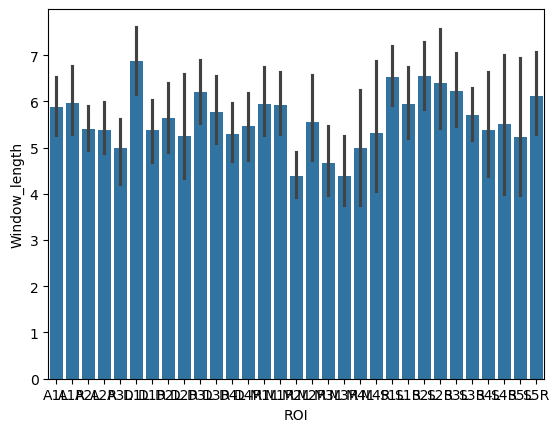

In [10]:
import seaborn as sns

sns.barplot(data=sig_window_stim_info.sort_values(by=['ROI']), x='ROI', y='Window_length')

In [11]:
transcribe_model = whisper.load_model("small")

In [12]:
if os.path.exists(outp_dir+'sig_window_text.csv'):
    sig_window_stim_info = pd.read_csv(outp_dir+'sig_window_text.csv', index_col=0)
else:
    prev_clip_name = sig_window_stim_info.loc[0, 'Video']
    video_raw = VideoFileClip(data_dir+prev_clip_name+'.avi')
    
    for i_row in sig_window_stim_info.index:
        clip_name=sig_window_stim_info.loc[i_row, 'Video']
        clip_start=round(sig_window_stim_info.loc[i_row, 'Time_start'], 2)
        clip_end=round(sig_window_stim_info.loc[i_row, 'Time_end'], 2)
    
        audio_path = audio_dir + clip_name+'_'+str(clip_start)+'-'+str(clip_end)+'.wav'
        if not os.path.isfile(audio_path):
        
            if clip_name == 'fixation':
                continue
    
            video_raw = VideoFileClip(data_dir+clip_name+'.avi')
            
            if clip_start > video_raw.duration:
                continue
            
            # Because of TRs, clip_end may be longer than the video duration
            # account for this by just taking the duration
            if clip_end > video_raw.duration:
                clip_end = np.floor(video_raw.duration)
        
            if clip_start > clip_end:
                continue
            
            video_clip = video_raw.subclipped(clip_start, clip_end)
        
            audio_clip = video_clip.audio
            audio_path = audio_dir + clip_name+'_'+str(clip_start)+'-'+str(clip_end)+'.wav'
            audio_clip.write_audiofile(audio_path, codec='pcm_s16le')
    
        # Transcribe
        result = transcribe_model.transcribe(audio_path, fp16=False)
        sig_window_stim_info.loc[i_row, 'Text'] = result['text']
    
    sig_window_stim_info.to_csv(outp_dir+'sig_window_text.csv')

ROI  Run   Video                        TRs  Time_start  Time_end  \
455  S1L    4  afv_hd            [287, 288, 289]      24.394    26.894   
54   M1L    4  afv_hd            [270, 271, 272]       3.144     5.644   
984  S3R    4  afv_hd  [303, 304, 305, 306, 307]      44.394    49.394   
985  S3R    4  afv_hd            [310, 311, 312]      53.144    55.644   
459  S1L    4  afv_hd  [324, 325, 326, 327, 328]      70.644    75.644   

     Window_length                                          Text  
455           3.75                             And the turkey...  
54            3.75   Stepping on gardening tools versus turkeys.  
984           6.25                I'm served! AAH! Is it enough?  
985           3.75                 Guys stepping on gardening to  
459           6.25                                       versus.

In [14]:
sig_window_stim_info['Text'] = sig_window_stim_info['Text'].fillna('')

sig_window_stim_info.head()

ROI  Run   Video                        TRs  Time_start  Time_end  \
455  S1L    4  afv_hd            [287, 288, 289]      24.394    26.894   
54   M1L    4  afv_hd            [270, 271, 272]       3.144     5.644   
984  S3R    4  afv_hd  [303, 304, 305, 306, 307]      44.394    49.394   
985  S3R    4  afv_hd            [310, 311, 312]      53.144    55.644   
459  S1L    4  afv_hd  [324, 325, 326, 327, 328]      70.644    75.644   

     Window_length                                          Text  
455           3.75                             And the turkey...  
54            3.75   Stepping on gardening tools versus turkeys.  
984           6.25                I'm served! AAH! Is it enough?  
985           3.75                 Guys stepping on gardening to  
459           6.25                                       versus.

In [17]:
sig_window_stim_info[sig_window_stim_info['ROI'] == 'S1R'].head()

ROI  Run       Video                        TRs  Time_start  Time_end  \
906  S1R    4      afv_hd            [298, 299, 300]      38.144    40.644   
907  S1R    4      afv_hd            [303, 304, 305]      44.394    46.894   
908  S1R    4      afv_hd  [317, 318, 319, 320, 321]      61.894    66.894   
869  S1R    1  awkward_hd       [345, 346, 347, 348]      63.633    67.383   
871  S1R    1  awkward_hd            [388, 389, 390]     117.383   119.883   

     Window_length                                               Text  
906           3.75                                                     
907           3.75                                        I'm served!  
908           6.25               with milk mustaches. Oh my goodness.  
869           5.00   It didn't work, and I knew from experience th...  
871           3.75   You need to move it. You cannot touch my tray...

In [18]:
sig_window_stim_info[sig_window_stim_info['ROI'] == 'S3R'].head()

ROI  Run       Video                        TRs  Time_start  Time_end  \
984  S3R    4      afv_hd  [303, 304, 305, 306, 307]      44.394    49.394   
985  S3R    4      afv_hd            [310, 311, 312]      53.144    55.644   
983  S3R    4      afv_hd            [298, 299, 300]      38.144    40.644   
954  S3R    1  awkward_hd       [411, 412, 413, 414]     146.133   149.883   
953  S3R    1  awkward_hd       [388, 389, 390, 391]     117.383   121.133   

     Window_length                                               Text  
984           6.25                     I'm served! AAH! Is it enough?  
985           3.75                      Guys stepping on gardening to  
983           3.75                                                     
954           5.00   my solution. I was going to create a fake rea...  
953           5.00   You need to move this. You cannot touch my tr...

In [19]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
temp_roi = 'S3R'
docs = sig_window_stim_info[sig_window_stim_info['ROI'] == temp_roi]['Text'].to_list()

In [21]:
docs

[" I'm served! AAH! Is it enough?",
 ' Guys stepping on gardening to',
 '',
 ' my solution. I was going to create a fake reality show in which',
 ' You need to move this. You cannot touch my tray, that is crazy. This.',
 " That's how I like to drink my smoothie.",
 ' that pushed her to pursue a career in ballet. She went on to become one of the few',
 ' this and it began morphine and changing and then people began asking',
 " It's right at 80, 38 seconds ago. The final seconds to decide.",
 " I'm the manager! What? I'm...",
 ' I asked for the room',
 ' The hell bedroom window? Sydney Opera?',
 " You can see the sea. It's over there between the land and the sky. I need a telescope to see...",
 ' I can fix it you scabby old bat.',
 ' I do have a hearing aid. Would you like me to get it mended? Mended.',
 ' What? I am the owner. I want to speak to the manager. I am the manager too. What? I am the manager as...',
 " all such matters I'm sure she will be delighted",
 ' a lunch will be serve

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [23]:
temp_roi = 'S1R'
docs = sig_window_stim_info[sig_window_stim_info['ROI'] == temp_roi]['Text'].to_list()

vectorizer_model = CountVectorizer(stop_words="english")
topic_model_a = BERTopic(vectorizer_model=vectorizer_model, min_topic_size=2)
topics, probs = topic_model_a.fit_transform(docs)
topic_model_a.get_topic_info()

Topic  Count                                Name  \
0     -1      8       -1_manager_yes_thats_outgoing   
1      0     11             0_ddweud_maen_yma_thank   
2      1      8  1_interruption_standoff_ship_sense   
3      2      8                2_just_tray_thats_im   
4      3      6              3_women_mended_im_work   
5      4      6       4_foul_injury_illinois_second   
6      5      3          5_choice_think_tank_skills   

                                      Representation  \
0  [manager, yes, thats, outgoing, speak, sort, s...   
1  [ddweud, maen, yma, thank, suffer, spend, maer...   
2  [interruption, standoff, ship, sense, rescue, ...   
3  [just, tray, thats, im, lunch, coated, bigger,...   
4  [women, mended, im, work, handles, quality, of...   
5  [foul, injury, illinois, second, time, running...   
6  [choice, think, tank, skills, shark, right, qu...   

                                 Representative_Docs  
0  [ going to react, particularly considering the...  
1  [ I want to spend my life with you,  I just su...  
2  [ with milk mustaches. Oh my goodness.,  becau...  
3  [ They cook up so quick and aren't they gorgeo...  
4  [ I do have a hearing aid. Would you like me t...  
5  [ D Brown calls for the foul.,  second half, t...  
6  [ Do you have the necessary political skills t...

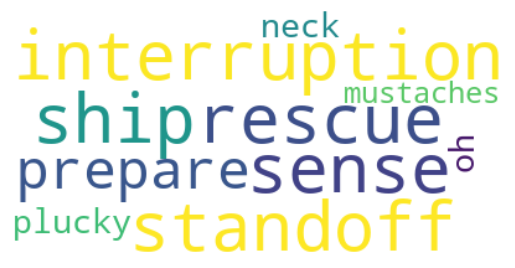

In [24]:
# Show wordcloud
create_wordcloud(topic_model_a, topic=1)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


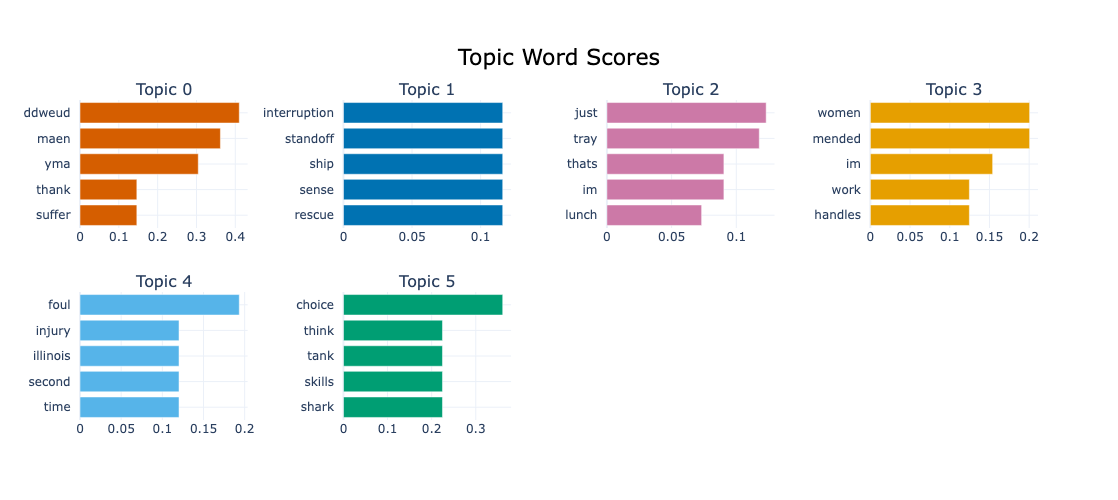

In [25]:
topic_model_a.visualize_barchart()

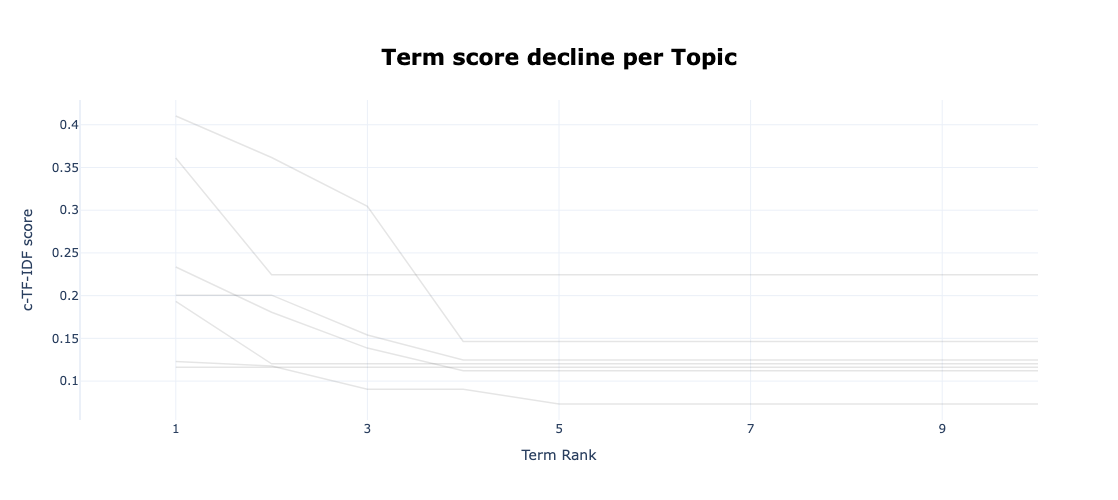

In [26]:
topic_model_a.visualize_term_rank()

In [27]:
from sentence_transformers import SentenceTransformer
from umap import UMAP

# Prepare embeddings
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=False)

# Train BERTopic and extract hierarchical topics
topic_model = BERTopic(min_topic_size=2).fit(docs, embeddings)
hierarchical_topics = topic_model.hierarchical_topics(docs)



100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 854.72it/s]


In [28]:
# Run the visualization with the original embeddings
topic_model.visualize_hierarchical_documents(docs, hierarchical_topics, embeddings=embeddings)

# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_hierarchical_documents(docs, hierarchical_topics, reduced_embeddings=reduced_embeddings)

IndexError: index -1 is out of bounds for axis 0 with size 0

In [31]:
temp_roi = 'S3R'
docs = sig_window_stim_info[sig_window_stim_info['ROI'] == temp_roi]['Text'].to_list()

vectorizer_model = CountVectorizer(stop_words="english")
topic_model_b = BERTopic(vectorizer_model=vectorizer_model, min_topic_size=2)
topics, probs = topic_model_b.fit_transform(docs)
topic_model_b.get_topic_info()


Topic  Count                                Name  \
0     -1      5               -1_guys_deli_joe_yara   
1      0      9  0_chicks_sea_accompanies_political   
2      1      8              1_thats_just_little_im   
3      2      7       2_tank_shark_think_investment   
4      3      6        3_manager_began_morphine_hmm   
5      4      5             4_mended_served_aah_aid   
6      5      3       5_seconds_said_right_question   

                                      Representation  \
0  [guys, deli, joe, yara, outgoing, gardening, f...   
1  [chicks, sea, accompanies, political, land, pe...   
2  [thats, just, little, im, want, going, youre, ...   
3  [tank, shark, think, investment, fought, 80000...   
4  [manager, began, morphine, hmm, opera, changin...   
5  [mended, served, aah, aid, scabby, runs, old, ...   
6  [seconds, said, right, question, 38, 80, final...   

                                 Representative_Docs  
0  [ Guys stepping on gardening to,  offer on the...  
1  [ You can see the sea. It's over there between...  
2  [ gonna flip it around in there get it evenly ...  
3  [,  an offer of $80,000 for 25% in the...,  Th...  
4  [ I'm the manager! What? I'm...,  this and it ...  
5  [ I'm served! AAH! Is it enough?,  I can fix i...  
6  [ That's what the question was in the beginnin...

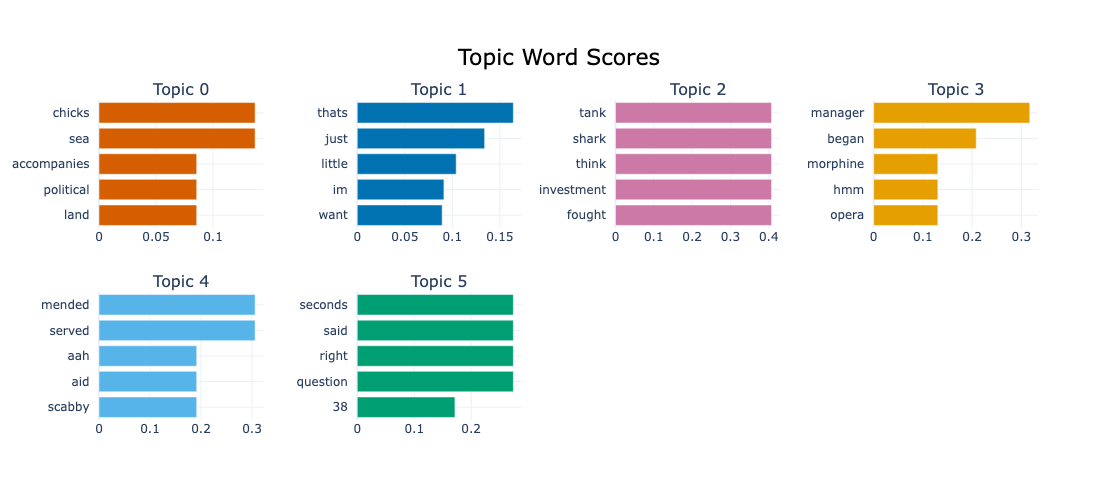

In [32]:
topic_model_b.visualize_barchart()

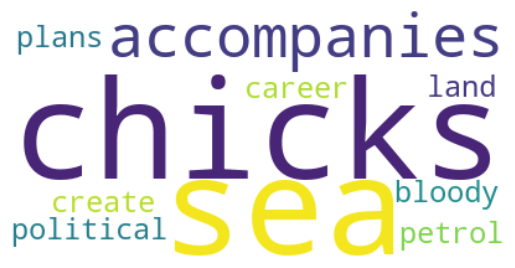

In [34]:
# Show wordcloud
create_wordcloud(topic_model_b, topic=0)

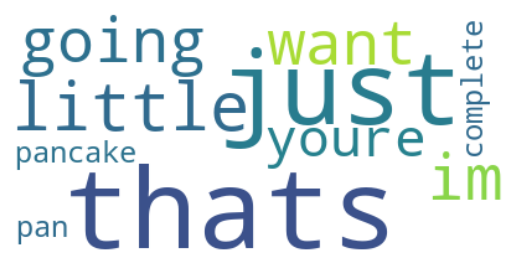

In [35]:
# Show wordcloud
create_wordcloud(topic_model_b, topic=1)

In [57]:
vectorizer_model = CountVectorizer(stop_words="english")

topic_model_rois = dict()

for temp_roi in cb_roi_names:
    docs = sig_window_stim_info[sig_window_stim_info['ROI'] == temp_roi]['Text'].to_list()
    
    
    try:
        topic_model = BERTopic(vectorizer_model=vectorizer_model, min_topic_size=2)
        topics, probs = topic_model.fit_transform(docs)
        
        topic_model_rois[temp_roi] = topic_model.topic_embeddings_

    except:
        topic_model_rois[temp_roi] = np.array('NA')


In [58]:
topic_model_sim = pd.DataFrame(columns=cb_roi_names, index=cb_roi_names)

for temp_roi_a in cb_roi_names:
    if (topic_model_rois[temp_roi_a] == 'NA').any():
        topic_model_sim.loc[temp_roi_a] = 0
    else:
        for temp_roi_b in cb_roi_names:
            if (topic_model_rois[temp_roi_b] == 'NA').any():
                topic_model_sim.loc[:,temp_roi_b] = 0
            else:
                sim_matrix = cosine_similarity(topic_model_rois[temp_roi_a], 
                                               topic_model_rois[temp_roi_b])

                topic_model_sim.loc[temp_roi_a, temp_roi_b] = sim_matrix.mean()

    topic_model_sim[temp_roi_a] = pd.to_numeric(topic_model_sim[temp_roi_a])


<Axes: >

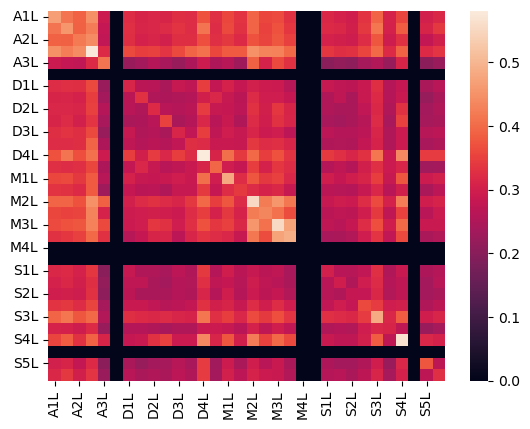

In [79]:
import seaborn as sns

sns.heatmap(topic_model_sim)

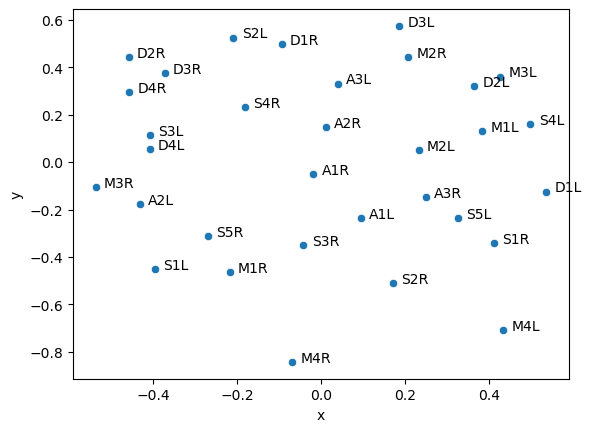

In [95]:
from sklearn.manifold import MDS

topic_model_dis = topic_model_sim - 1

md_scaling = MDS(
    n_components=2,
    dissimilarity='precomputed',
    max_iter=50,
    n_init=4,
    random_state=0,
    normalized_stress=False,
)
S_scaling = md_scaling.fit_transform(topic_model_dis)

S_scaling = pd.DataFrame(S_scaling, columns=['x','y'])
S_scaling['ROIs'] = topic_model_dis.columns.copy()

ax = sns.scatterplot(S_scaling, x='x', y='y', )

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(S_scaling.x, S_scaling.y, S_scaling.ROIs, plt.gca()) 


<Axes: >

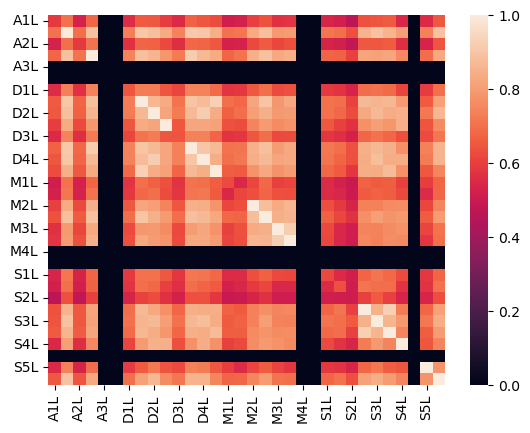

In [106]:
import seaborn as sns
# Old results 
sns.heatmap(topic_model_sim)

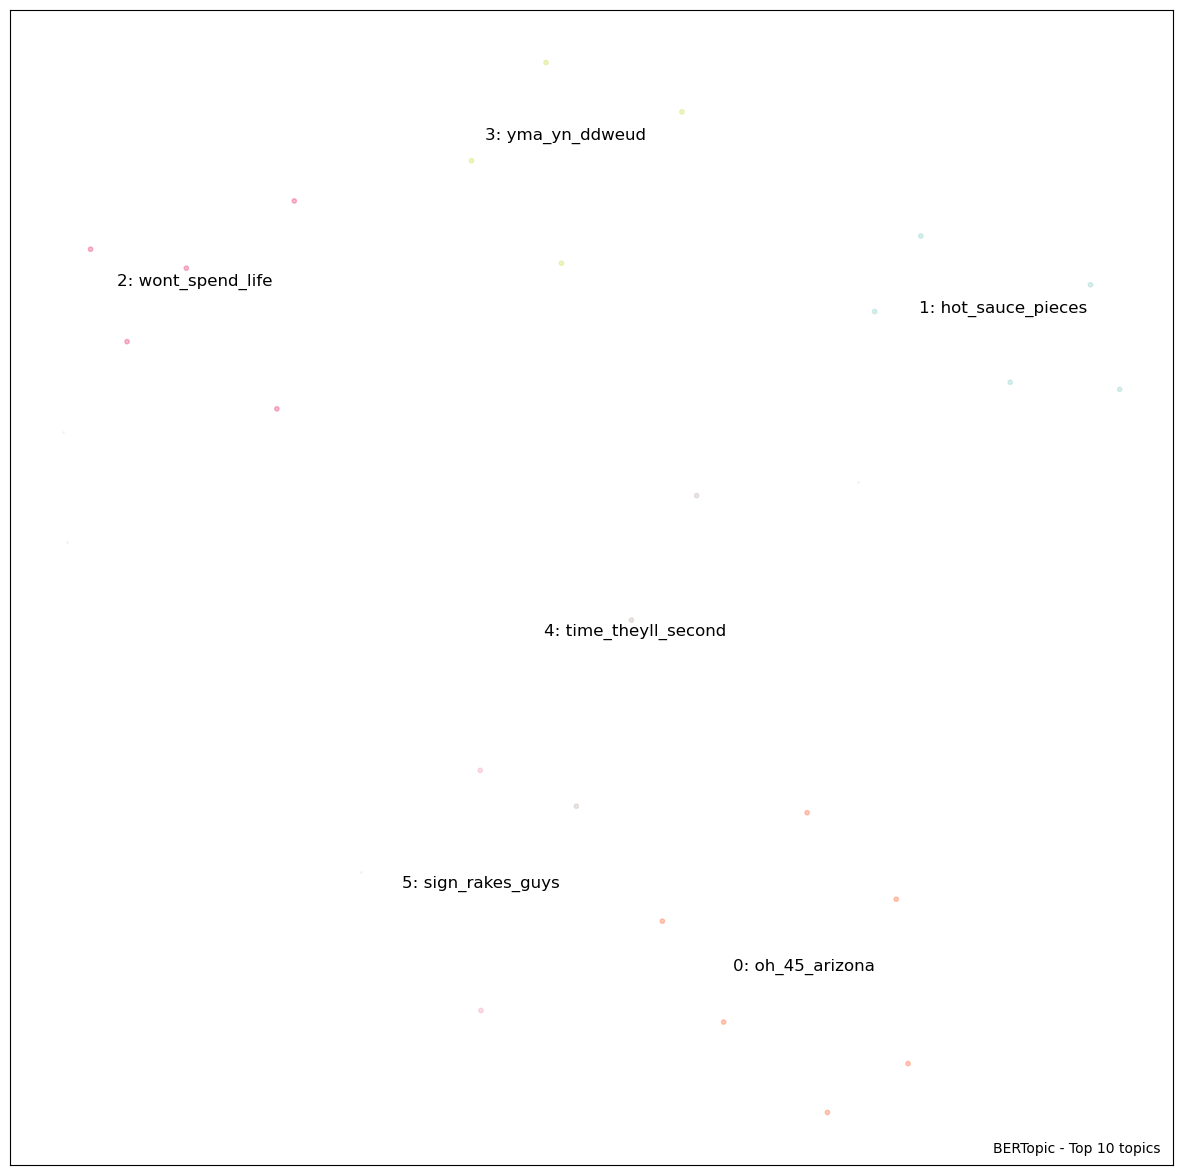

In [60]:
from umap import UMAP
 
import matplotlib
import matplotlib.pyplot as plt
  
# Prepare data for plotting
embeddings = topic_model._extract_embeddings(docs, method="document")
umap_model = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit(embeddings)
df = pd.DataFrame(umap_model.embedding_, columns=["x", "y"])
df["topic"] = topics
 
# Plot parameters
top_n = 10
fontsize = 12
 
# Slice data
to_plot = df.copy()
to_plot[df.topic >= top_n] = -1
outliers = to_plot.loc[to_plot.topic == -1]
non_outliers = to_plot.loc[to_plot.topic != -1]
 
# Visualize topics
cmap = matplotlib.colors.ListedColormap(['#FF5722', # Red
                                        '#03A9F4', # Blue
                                        '#4CAF50', # Green
                                        '#80CBC4', # FFEB3B
                                        '#673AB7', # Purple
                                        '#795548', # Brown
                                        '#E91E63', # Pink
                                        '#212121', # Black
                                        '#00BCD4', # Light Blue
                                        '#CDDC39', # Yellow/Red
                                        '#AED581', # Light Green
                                        '#FFE082', # Light Orange
                                        '#BCAAA4', # Light Brown
                                        '#B39DDB', # Light Purple
                                        '#F48FB1', # Light Pink
                                        ])
 
# Visualize outliers + inliers
fig, ax = plt.subplots(figsize=(15, 15))
scatter_outliers = ax.scatter(outliers['x'], outliers['y'], c="#E0E0E0", s=1, alpha=.3)
scatter = ax.scatter(non_outliers['x'], non_outliers['y'], c=non_outliers['topic'], s=10, alpha=.3, cmap=cmap)
 
# Add topic names to clusters
centroids = to_plot.groupby("topic").mean().reset_index().iloc[1:]
for row in centroids.iterrows():
   topic = int(row[1].topic)
   text = f"{topic}: " + "_".join([x[0] for x in topic_model.get_topic(topic)[:3]])
   ax.text(row[1].x, row[1].y*1.01, text, fontsize=fontsize, horizontalalignment='center')
 
ax.text(0.99, 0.01, f"BERTopic - Top {top_n} topics", transform=ax.transAxes, horizontalalignment="right", color="black")
plt.xticks([], [])
plt.yticks([], [])
#plt.savefig("BERTopic_Example_Cluster_Plot.png")
plt.show()